## TODOs

In [1]:
import analyze
import prep
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import altair as alt
from altair_saver import save
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
DATA_PATH = "../data/2020/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
outcome = "Wage"
data_2020, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2020)

DATA_PATH = "../data/2019/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
data_2019, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2019)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Removing 0 respondents with missing Wage
6284 developers left in the sample after cleaning
151 or 2.4% black developers in the sample with multiracial replacement
Removing 0 respondents with missing Wage
12502 developers left in the sample after cleaning
291 or 2.3% black developers in the sample with multiracial replacement


In [3]:
data = pd.concat([data_2020, data_2019], axis=0)

In [4]:
X, Y = prep.design_matrix(data, categorical, numeric, base, outcome)

Design matrix complete with 184 variables/columns


In [5]:
D = "Ethnicity"
results = analyze.analyze(Y, X, D)
results

,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
Ethnicity_Black_or_of_African_descent,-0.013597,0.018611,-0.730614,0.465015,-0.050074,0.022879,-0.07164,0.023054,-3.107465,0.00189,-0.116828,-0.026452


In [6]:
labels = ["Non-Black", "Black (Raw)", "Black (Adj.)"]
colors = ["#fa7026", "#14125b", "#612b8a"]

In [563]:
data_plot = pd.DataFrame({"data": [1.0, np.exp(results["coef_raw"][0]), np.exp(results["coef_ds"][0])],
                          "lower": [np.nan, np.exp(results["lower_raw"])[0], np.exp(results["lower_ds"])[0]],
                          "upper": [np.nan, np.exp(results["upper_raw"])[0], np.exp(results["upper_ds"])[0]],
                          "labels": ["Non-Black", "Black (Raw)", "Black (Adj.)"],
                          "Legend": ["95% Confidence Interval"] * 3})

In [564]:
data_plot

,data,lower,upper,labels,Legend
0,1.000000,NaN,NaN,Non-Black,95% Confidence Interval
1,0.930866,0.889738,0.973895,Black (Raw),95% Confidence Interval
2,0.986495,0.951159,1.023143,Black (Adj.),95% Confidence Interval


In [565]:
labels = ["Non-Black", "Black (Raw)", "Black (Adj.)"]
colors = ["#fa7026", "#14125b", "#612b8a"]

color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart(data_plot, title="Relative Compensation").mark_bar(size=70, cornerRadiusBottomRight=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("data", 
            axis=alt.Axis(format="$.2f", title=None, tickCount=5, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0.8, 1.05)
            )
    ),
    y=alt.Y("labels", 
            axis=alt.Axis(title=None, labelFontSize=15), 
            sort=labels),
    color=alt.Color(
        'labels',
        legend=None,
        scale=color_scale
    )
)

text = alt.Chart(data_plot).mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=-25,
    fontSize=20
).encode(
    text=alt.Text("data", format="$.2f"),
    x="data",
    y=alt.Y("labels", 
            sort=labels),
    color=alt.Color(
        'labels',
        scale=color_scale
    )
)

error_bars = alt.Chart(data_plot).mark_bar(color="#BAC1B8", size=3).encode(
    x="lower",
    x2="upper",
    y=alt.Y("labels", 
        sort=labels),
)

lower = alt.Chart(data_plot).mark_tick(color="#BAC1B8", thickness=3, opacity=1).encode(
    x="lower",
    y=alt.Y("labels", 
        sort=labels),
)

upper = alt.Chart(data_plot).mark_tick(color="#BAC1B8", thickness=3, opacity=1).encode(
    x="upper",
    y=alt.Y("labels", 
        sort=labels),
)

chart = (points + text + error_bars + lower + upper).properties(
    width=500,
    height=300,
    title={
        "text": "Relative Compensation", 
        "subtitle": "Raw: No controls, Adj: With controls, 95% Confidence Interval",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("relative_compensation.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

In [836]:
qu=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for q in qu:
    print(Y[X["Ethnicity_Black_or_of_African_descent"] == 1].quantile(q) - Y[X["Ethnicity_Black_or_of_African_descent"] == 0].quantile(q))

-0.06811331604603943
-0.06279613301716669
-0.06099282340329326
-0.04471839368826469
-0.06551460711062651
-0.08311197583411722
-0.06453852113757108
-0.06479204636015101
-0.13138445156304002


In [922]:
data = []
lower = []
upper = []
labels = []
index = []

quantiles = 10

for q in range(1, quantiles):
    model = sm.QuantReg(endog=Y, exog=X[[col for col in X.columns if "Ethnicity" in col] + ["Year_2020"]].assign(const=1)).fit(q=q/quantiles)
    data.append(model.params[0])
    lower.append(model.conf_int().values[0][0])
    upper.append(model.conf_int().values[0][1])
    labels.append("Black (Raw)")
    index.append(q/quantiles)
    
data = data + [0.0] * quantiles
lower = lower + [np.nan] * quantiles
upper = upper + [np.nan] * quantiles
labels = labels + ["Non-Black"] * quantiles
index = index + index

In [923]:
results_q_plot = pd.DataFrame(zip(index, labels, data, lower, upper), columns=["index", "labels", "data", "lower", "upper"])
results_q_plot["data"] = np.exp(results_q_plot["data"])
results_q_plot["lower"] = np.exp(results_q_plot["lower"])
results_q_plot["upper"] = np.exp(results_q_plot["upper"])
results_q_plot["label_height"] = 1.0

In [924]:
results_q_plot

,index,labels,data,lower,upper,label_height
0,0.1,Black (Raw),0.929771,0.859733,1.005514,1.0
1,0.2,Black (Raw),0.942858,0.889332,0.999605,1.0
2,0.3,Black (Raw),0.937500,0.888746,0.988929,1.0
3,0.4,Black (Raw),0.944449,0.895236,0.996367,1.0
4,0.5,Black (Raw),0.933326,0.887688,0.981311,1.0
5,0.6,Black (Raw),0.922853,0.876944,0.971166,1.0
6,0.7,Black (Raw),0.944882,0.897253,0.995038,1.0
7,0.8,Black (Raw),0.944061,0.891549,0.999667,1.0
8,0.9,Black (Raw),0.885000,0.817749,0.957783,1.0
9,0.1,Non-Black,1.000000,NaN,NaN,1.0


In [926]:
labels = ["Non-Black", "Black (Raw)"]
colors = ["#fa7026", "#612b8a"]

color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=25, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format="$.2f", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0.8, 1.1)
            )
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=100,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    angle=0,
    baseline='middle',
    dx=-0,
    dy=-20,
    fontSize=12
).encode(
    text=alt.Text("data", format="$.2f"),
    x=alt.X("labels", 
            sort=labels),
    y="label_height",
    color=alt.Color("labels", 
                    scale=color_scale)
)

error_bars = alt.Chart().mark_bar(color="#BAC1B8", size=2).encode(
    x=alt.X("labels",
            sort=labels),
    y="lower",
    y2="upper",
)

lower = alt.Chart().mark_tick(color="#BAC1B8", thickness=2, opacity=1).encode(
    x=alt.X("labels",
            sort=labels),
    y="lower",
)

upper = alt.Chart().mark_tick(color="#BAC1B8", thickness=2, opacity=1).encode(
    x=alt.Y("labels",
            sort=labels),
    y="upper",
)

chart = alt.layer(points, text, error_bars, lower, upper, data=results_q_plot).facet(
    column=alt.Column("index", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Relative Compensation by Income Quintile", 
        "subtitle": "Raw: No controls, 95% Confidence Interval",
        "subtitleColor": "gray",
        "dy": 25
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

#chart.save("relative_compensation_quintile.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)

In [886]:
X_q = {}
Y_q = {}
quantiles = 5

for q in range(1, quantiles+1):
    X_q[q] = X.loc[(Y <= Y.quantile(q/quantiles)) & (Y > Y.quantile(q/quantiles-(1/quantiles)))]
    Y_q[q] = Y.loc[(Y <= Y.quantile(q/quantiles)) & (Y > Y.quantile(q/quantiles-(1/quantiles)))]

In [887]:
D = "Ethnicity"
results_q = []
for q in range(1, quantiles+1):
    results_q.append(analyze.analyze(Y_q[q], X_q[q], D))
    
results_q = pd.concat(results_q, axis=0)
results_q.index = range(1, quantiles+1)

In [888]:
results_q

,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
1,-0.006312,0.032327,-0.195261,0.845189,-0.069673,0.057048,0.000121,0.034380,0.003519,0.997193,-0.067285,0.067526
2,0.002529,0.007531,0.335848,0.736985,-0.012232,0.017291,0.001517,0.007564,0.200571,0.841045,-0.013313,0.016347
3,0.000301,0.006578,0.045738,0.963519,-0.012591,0.013193,-0.000715,0.006558,-0.109028,0.913186,-0.013573,0.012143
4,0.013146,0.008065,1.630031,0.103095,-0.002661,0.028954,0.014625,0.007962,1.836757,0.066324,-0.000986,0.030235
5,-0.036317,0.029701,-1.222774,0.221415,-0.094529,0.021895,-0.044368,0.031446,-1.410937,0.158347,-0.106022,0.017285


In [889]:
results_q_plot = pd.melt(results_q.reset_index()[["index", "coef_ds", "coef_raw"]], id_vars=["index"]).rename(columns={"value": "data", "variable": "labels"})

In [890]:
results_q_plot["lower"] = np.exp(pd.melt(results_q.reset_index()[["index", "lower_ds", "lower_raw"]], id_vars=["index"])["value"])
results_q_plot["upper"] = np.exp(pd.melt(results_q.reset_index()[["index", "upper_ds", "upper_raw"]], id_vars=["index"])["value"])
results_q_plot["data"] = np.exp(results_q_plot["data"])

In [891]:
results_q_plot.loc[results_q_plot["labels"] == "coef_ds", "labels"] = "Black (Adj.)"
results_q_plot.loc[results_q_plot["labels"] == "coef_raw", "labels"] = "Black (Raw)"

In [892]:
results_q_plot = pd.concat([results_q_plot, pd.DataFrame({"index": range(1, quantiles+1), "labels": "Non-Black", "data": 1.0})])

In [893]:
results_q_plot["label_height"] = 1.09

In [894]:
results_q_plot

,index,labels,data,lower,upper,label_height
0,1,Black (Adj.),0.993708,0.932699,1.058707,1.09
1,2,Black (Adj.),1.002533,0.987843,1.017441,1.09
2,3,Black (Adj.),1.000301,0.987488,1.013280,1.09
3,4,Black (Adj.),1.013233,0.997343,1.029377,1.09
4,5,Black (Adj.),0.964334,0.909801,1.022136,1.09
5,1,Black (Raw),1.000121,0.934929,1.069859,1.09
6,2,Black (Raw),1.001518,0.986776,1.016481,1.09
7,3,Black (Raw),0.999285,0.986519,1.012217,1.09
8,4,Black (Raw),1.014732,0.999015,1.030697,1.09
9,5,Black (Raw),0.956602,0.899405,1.017435,1.09


In [791]:
labels = ["Non-Black", "Black (Raw)", "Black (Adj.)"]
colors = ["#fa7026", "#14125b", "#612b8a"]

color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=25, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format="$.2f", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0.8, 1.1)
            )
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=100,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    angle=0,
    baseline='middle',
    dx=-0,
    dy=-20,
    fontSize=12
).encode(
    text=alt.Text("data", format="$.2f"),
    x=alt.X("labels", 
            sort=labels),
    y="label_height",
    color=alt.Color("labels", 
                    scale=color_scale)
)

error_bars = alt.Chart().mark_bar(color="#BAC1B8", size=2).encode(
    x=alt.X("labels",
            sort=labels),
    y="lower",
    y2="upper",
)

lower = alt.Chart().mark_tick(color="#BAC1B8", thickness=2, opacity=1).encode(
    x=alt.X("labels",
            sort=labels),
    y="lower",
)

upper = alt.Chart().mark_tick(color="#BAC1B8", thickness=2, opacity=1).encode(
    x=alt.Y("labels",
            sort=labels),
    y="upper",
)

chart = alt.layer(points, text, error_bars, lower, upper, data=results_q_plot).facet(
    column=alt.Column("index", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Relative Compensation by Income Quintile", 
        "subtitle": "Raw: No controls, Adj: With controls, 95% Confidence Interval",
        "subtitleColor": "gray",
        "dy": 25
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("relative_compensation_quintile.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)

In [559]:
for q in range(1, quantiles+1):
    print(np.exp(Y_q[q].mean()) * 40 * 50)

53917.585132009175
83017.52074051513
104755.31288370208
131471.84304238926
197819.93225072624


In [562]:
for q in range(1, quantiles+1):
    print(X_q[q]["YearsCodePro"].mean())

4.745142400851743
7.197631088634549
10.200398936170213
12.366526537046768
13.73076923076923


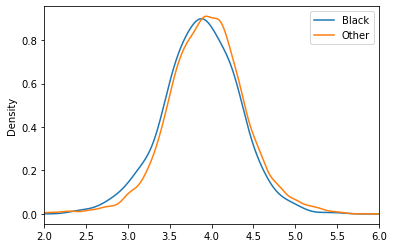

In [107]:
data[data["Ethnicity"].str.contains("Black")].Wage.plot.kde()
data[data["Ethnicity"].str.contains("Other")].Wage.plot.kde()
plt.xlim(2,6)
plt.legend(["Black", "Other"])
plt.show()

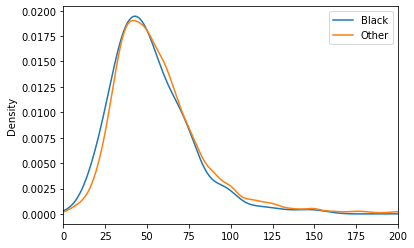

In [108]:
np.exp(data[data["Ethnicity"].str.contains("Black")].Wage).plot.kde()
np.exp(data[data["Ethnicity"].str.contains("Other")].Wage).plot.kde()
plt.xlim(0,200)
plt.legend(["Black", "Other"])
plt.show()

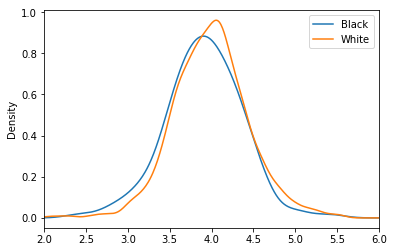

In [188]:
data[data["Ethnicity"].str.contains("Black")].Wage.plot.kde()
data[data["Ethnicity"].str.contains("White")].Wage.plot.kde()
plt.xlim(2,6)
plt.legend(["Black", "White"])
plt.show()

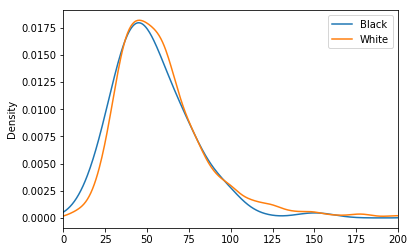

In [189]:
np.exp(data[data["Ethnicity"].str.contains("Black")].Wage).plot.kde()
np.exp(data[data["Ethnicity"].str.contains("White")].Wage).plot.kde()
plt.xlim(0,200)
plt.legend(["Black", "White"])
plt.show()

In [109]:
print(data[data["Ethnicity"].str.contains("Black")].Wage.mean() - data[data["Ethnicity"].str.contains("Other")].Wage.mean())
print(np.exp(data[data["Ethnicity"].str.contains("Black")].Wage.mean() - data[data["Ethnicity"].str.contains("Other")].Wage.mean()) - 1)

-0.07115695134400424
-0.06868429059617853


In [190]:
print(data[data["Ethnicity"].str.contains("Black")].Wage.mean() - data[data["Ethnicity"].str.contains("White")].Wage.mean())
print(np.exp(data[data["Ethnicity"].str.contains("Black")].Wage.mean() - data[data["Ethnicity"].str.contains("White")].Wage.mean()) - 1)

-0.07979935023686613
-0.07669841195339067


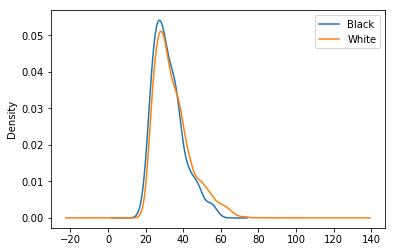

In [193]:
data[data["Ethnicity"].str.contains("Black")].Age.plot.kde()
data[data["Ethnicity"].str.contains("White")].Age.plot.kde()
plt.legend(["Black", "White"])
plt.show()

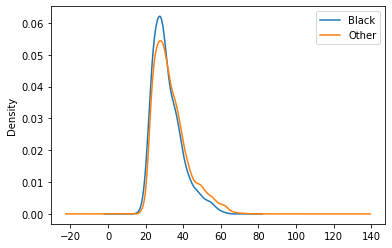

In [112]:
data[data["Ethnicity"].str.contains("Black")].Age.plot.kde()
data[data["Ethnicity"].str.contains("Other")].Age.plot.kde()
plt.legend(["Black", "Other"])
plt.show()